In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import glob # Import glob for finding files

# Configurações gerais
EPOCHS = 200
LEARNING_RATE = 2e-3
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")

# Caminho para o dataset "Doencas-Olhos"
DATA_DIR = 'datasetsTCC/Lung-X-Ray-Image'

# 1. Definir as transformações da imagem
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2. Criar um Dataset customizado para carregar todas as imagens recursivamente
class AllImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None): # Corrected argument name to root_dir
        self.root_dir = root_dir
        self.transform = transform
        # Find all image files (jpg, jpeg, png) recursively
        self.image_files = glob.glob(os.path.join(self.root_dir, '**', '*.jpg'), recursive=True) + \
                           glob.glob(os.path.join(self.root_dir, '**', '*.jpeg'), recursive=True) + \
                           glob.glob(os.path.join(self.root_dir, '**', '*.png'), recursive=True)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB') # Open as RGB first to handle different formats

        if self.transform:
            image = self.transform(image)

        return image, 0 # Return image and a dummy label (0) as we don't have class info here

# Carregar o dataset usando o Dataset customizado
# Como não estamos separando treino e teste explicitamente nesta abordagem,
# vamos carregar todas as imagens e depois splitar manualmente se necessário
full_dataset = AllImagesDataset(root_dir=DATA_DIR, transform=transform) # Corrected argument name to root_dir

# Split dataset into train and test (optional, depending on model training needs)
# For autoencoders, often the same data is used for input and target, so a simple split might not be needed
# However, if you want to train on a subset and test on another, uncomment the lines below:
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# For now, let's use the full dataset for the loader as autoencoders often train on all data
train_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False) # Use full dataset for testing visualization

print(f"Número total de imagens encontradas: {len(full_dataset)}")


# Função para visualizar as imagens
def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    # Ensure we don't plot more than available images
    num_images_to_plot = min(n, original.size(0))
    for i in range(num_images_to_plot):
        # Imagem original
        ax = plt.subplot(2, num_images_to_plot, i + 1)
        # Desnormaliza a imagem para o intervalo [0, 1] para exibição
        img = original[i].cpu().numpy().squeeze() * 0.5 + 0.5
        plt.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_images_to_plot // 2:
            ax.set_title("Originais")

        # Imagem reconstruída
        ax = plt.subplot(2, num_images_to_plot, i + 1 + num_images_to_plot)
        # Desnormaliza a imagem para o intervalo [0, 1] para exibição
        rec_img = reconstructed[i].cpu().numpy().squeeze() * 0.5 + 0.5
        plt.imshow(rec_img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == num_images_to_plot // 2:
            ax.set_title("Reconstruídas")
    plt.show()


Usando dispositivo: cuda
Número total de imagens encontradas: 3475


Vanilla AE | Epoch [1/200], Loss: 0.1089
Vanilla AE | Epoch [2/200], Loss: 0.0417
Vanilla AE | Epoch [3/200], Loss: 0.0330
Vanilla AE | Epoch [4/200], Loss: 0.0298
Vanilla AE | Epoch [5/200], Loss: 0.0281
Vanilla AE | Epoch [6/200], Loss: 0.0267
Vanilla AE | Epoch [7/200], Loss: 0.0254
Vanilla AE | Epoch [8/200], Loss: 0.0245
Vanilla AE | Epoch [9/200], Loss: 0.0230
Vanilla AE | Epoch [10/200], Loss: 0.0219
Vanilla AE | Epoch [11/200], Loss: 0.0204
Vanilla AE | Epoch [12/200], Loss: 0.0198
Vanilla AE | Epoch [13/200], Loss: 0.0193
Vanilla AE | Epoch [14/200], Loss: 0.0186
Vanilla AE | Epoch [15/200], Loss: 0.0180
Vanilla AE | Epoch [16/200], Loss: 0.0186
Vanilla AE | Epoch [17/200], Loss: 0.0174
Vanilla AE | Epoch [18/200], Loss: 0.0165
Vanilla AE | Epoch [19/200], Loss: 0.0162
Vanilla AE | Epoch [20/200], Loss: 0.0160
Vanilla AE | Epoch [21/200], Loss: 0.0157
Vanilla AE | Epoch [22/200], Loss: 0.0154
Vanilla AE | Epoch [23/200], Loss: 0.0152
Vanilla AE | Epoch [24/200], Loss: 0.0159
V

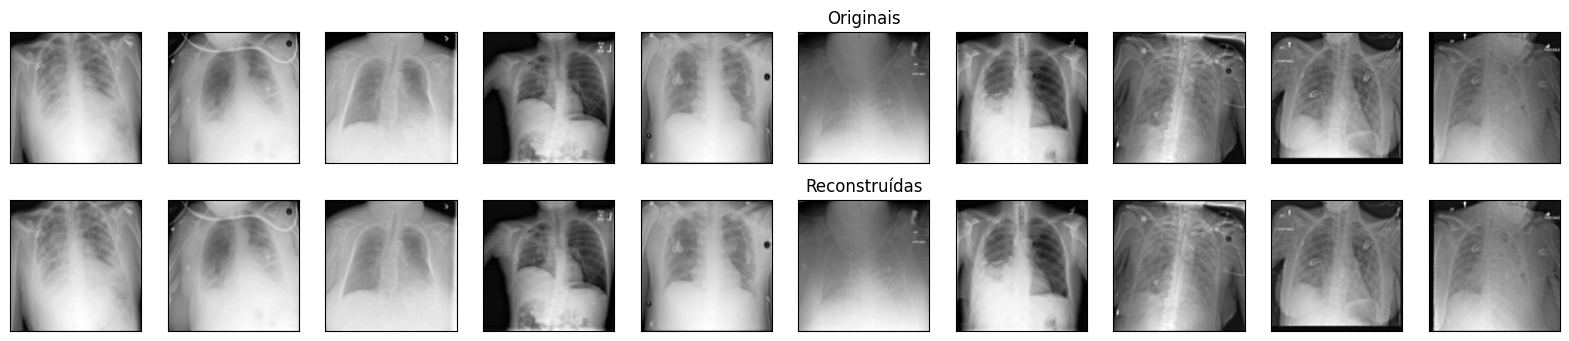

In [2]:
# 1. Definição do Modelo Vanilla Autoencoder
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()

        # Encoder: Reduz a imagem espacialmente e aumenta a profundidade (canais)
        self.encoder = nn.Sequential(
            # Entrada: [N, 1, 128, 128] (N = batch_size)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),  # -> [N, 16, 64, 64]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> [N, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> [N, 64, 16, 16]
            #nn.ReLU(),
            #nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # -> [N, 128, 8, 8] (Representação latente)
        )

        self.decoder = nn.Sequential(
            # Entrada: [N, 128, 8, 8]
            #nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 64, 16, 16]
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> [N, 1, 128, 128]
            nn.Tanh() # Escala a saída para [-1, 1], igual à normalização da entrada
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 2. Treinamento do Modelo
model_vanilla = ConvolutionalAutoencoder().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_vanilla.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    total_loss = 0
    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        outputs = model_vanilla(images)

        # Achatamos as imagens originais para calcular a perda com a saída achatada do decoder
        # (O modelo já remodela a saída, então comparamos imagens com imagens)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Vanilla AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")

# 3. Visualização dos Resultados
print("\n--- Visualizando resultados do Vanilla Autoencoder ---")
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    reconstructed_images = model_vanilla(test_images)
    plot_images(test_images, reconstructed_images)

Autoencoder VAE

VAE | Epoch [1/200], Average Loss: 1274.5325
VAE | Epoch [2/200], Average Loss: 414.8144
VAE | Epoch [3/200], Average Loss: 283.1564
VAE | Epoch [4/200], Average Loss: 232.3246
VAE | Epoch [5/200], Average Loss: 206.0104
VAE | Epoch [6/200], Average Loss: 182.6610
VAE | Epoch [7/200], Average Loss: 172.0515
VAE | Epoch [8/200], Average Loss: 162.0274
VAE | Epoch [9/200], Average Loss: 156.4644
VAE | Epoch [10/200], Average Loss: 152.4865
VAE | Epoch [11/200], Average Loss: 153.4424
VAE | Epoch [12/200], Average Loss: 144.6538
VAE | Epoch [13/200], Average Loss: 142.9552
VAE | Epoch [14/200], Average Loss: 140.1833
VAE | Epoch [15/200], Average Loss: 139.9890
VAE | Epoch [16/200], Average Loss: 136.0147
VAE | Epoch [17/200], Average Loss: 135.2780
VAE | Epoch [18/200], Average Loss: 133.6525
VAE | Epoch [19/200], Average Loss: 133.9664
VAE | Epoch [20/200], Average Loss: 131.9571
VAE | Epoch [21/200], Average Loss: 131.4703
VAE | Epoch [22/200], Average Loss: 128.3423
VAE | Epoch [23/20

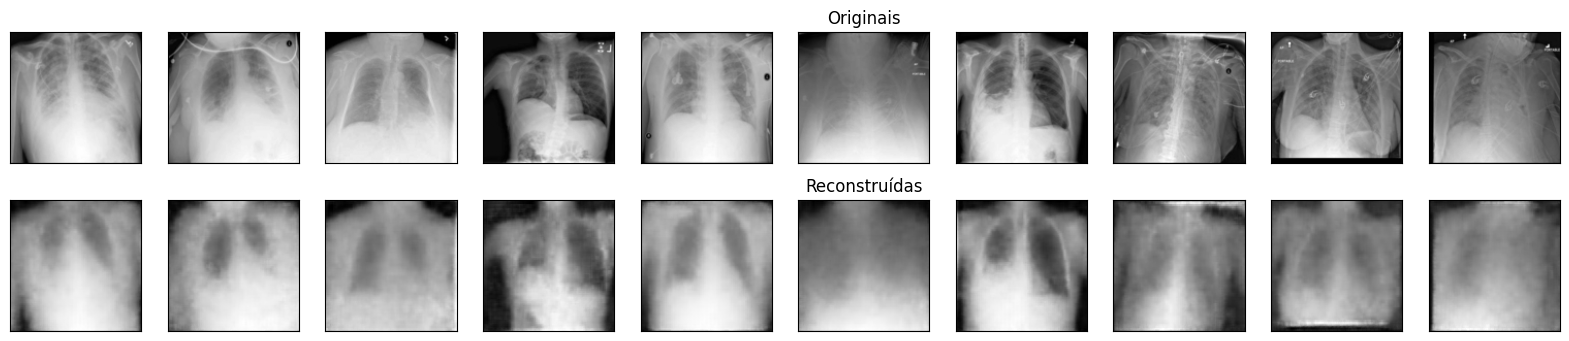

In [3]:
class ConvolutionalVAE(nn.Module):
    def __init__(self, latent_dim=32): # Adjusted latent_dim
        super(ConvolutionalVAE, self).__init__()

        # --- ENCODER ---
        # Converte a imagem de entrada em um vetor de características achatado
        self.encoder_conv = nn.Sequential(
            # Input: [N, 1, 128, 128] - Supondo imagem em escala de cinza
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1), # -> [N, 16, 64, 64] - Adjusted channels
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1), # -> [N, 32, 32, 32] - Adjusted channels
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> [N, 64, 16, 16] - Adjusted channels
            nn.ReLU(),
        )

        # Achatamos a saída da convolução e passamos por uma camada linear
        # O tamanho 64 * 16 * 16 vem da saída da última camada Conv2d
        self.flattened_size = 64 * 16 * 16 # Adjusted size

        # Duas camadas lineares para gerar mu e log_var
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_log_var = nn.Linear(self.flattened_size, latent_dim)

        # --- DECODER ---
        # Camada linear para começar a expansão a partir do espaço latente
        self.decoder_fc = nn.Linear(latent_dim, self.flattened_size)

        # Camadas convolucionais transpostas para reconstruir a imagem
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # -> [N, 32, 32, 32] - Adjusted channels
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # -> [N, 16, 64, 64] - Adjusted channels
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1), # -> [N, 1, 128, 128] - Adjusted channels
            nn.Tanh() # Usamos Sigmoid para escalar a saída para [0, 1]
        )

    def reparameterize(self, mu, log_var):
        """O Truque da Reparametrização."""
        std = torch.exp(0.5 * log_var)  # std = sqrt(variance) = sqrt(exp(log_var)) = exp(0.5 * log_var)
        eps = torch.randn_like(std)     # Gera um erro aleatório com a mesma forma de std
        return mu + eps * std           # Retorna a amostra z

    def forward(self, x):
        # 1. Passa pela parte convolucional do encoder e achata
        h = self.encoder_conv(x)
        h = h.view(-1, self.flattened_size)

        # 2. Obtém mu e log_var
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)

        # 3. Obtém a amostra z usando o truque da reparametrização
        z = self.reparameterize(mu, log_var)

        # 4. Passa z pelo decoder para reconstruir a imagem
        recon_h = self.decoder_fc(z)
        recon_h = recon_h.view(-1, 64, 16, 16) # Remodela para o formato de imagem antes das convoluções transpostas - Adjusted size
        recon_x = self.decoder_conv(recon_h)

        return recon_x, mu, log_var

def loss_function(recon_x, x, mu, log_var, beta=0.1): # Adicione beta como argumento
    # Perda de Reconstrução com Mean Squared Error
    RECON_LOSS = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # Divergência KL (permanece a mesma)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Retorna a perda ponderada
    return RECON_LOSS + beta * KLD

# 2. Treinamento do Modelo
model_vae = ConvolutionalVAE().to(DEVICE)
optimizer = optim.Adam(model_vae.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    total_loss = 0
    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        # Forward pass
        recon_images, mu, log_var = model_vae(images)
        loss = loss_function(recon_images, images, mu, log_var, beta = 0.1)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"VAE | Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}")

print("\n--- Visualizando resultados do VAE Autoencoder ---")
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    reconstructed_images, _, _ = model_vae(test_images)
    plot_images(test_images, reconstructed_images)

Denoising AutoEncoder

Denoising AE | Epoch [1/200], Loss: 0.1444
Denoising AE | Epoch [2/200], Loss: 0.0464
Denoising AE | Epoch [3/200], Loss: 0.0370
Denoising AE | Epoch [4/200], Loss: 0.0335
Denoising AE | Epoch [5/200], Loss: 0.0312
Denoising AE | Epoch [6/200], Loss: 0.0296
Denoising AE | Epoch [7/200], Loss: 0.0289
Denoising AE | Epoch [8/200], Loss: 0.0277
Denoising AE | Epoch [9/200], Loss: 0.0273
Denoising AE | Epoch [10/200], Loss: 0.0269
Denoising AE | Epoch [11/200], Loss: 0.0266
Denoising AE | Epoch [12/200], Loss: 0.0263
Denoising AE | Epoch [13/200], Loss: 0.0263
Denoising AE | Epoch [14/200], Loss: 0.0261
Denoising AE | Epoch [15/200], Loss: 0.0257
Denoising AE | Epoch [16/200], Loss: 0.0254
Denoising AE | Epoch [17/200], Loss: 0.0253
Denoising AE | Epoch [18/200], Loss: 0.0253
Denoising AE | Epoch [19/200], Loss: 0.0251
Denoising AE | Epoch [20/200], Loss: 0.0253
Denoising AE | Epoch [21/200], Loss: 0.0249
Denoising AE | Epoch [22/200], Loss: 0.0248
Denoising AE | Epoch [23/200], Loss: 0.02

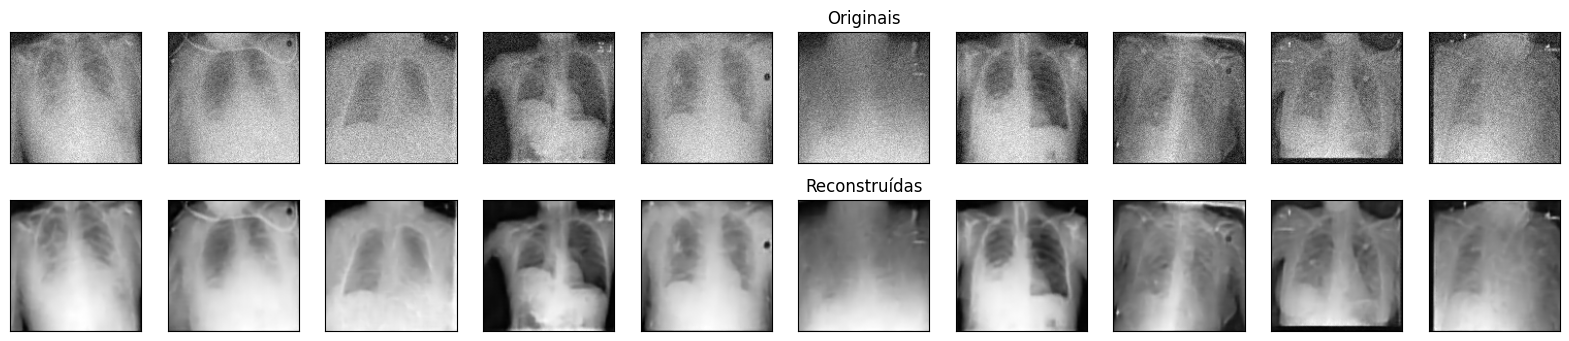

In [4]:
# 1. Definição do Modelo Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            # Entrada: [N, 1, 128, 128] (N = batch_size)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),  # -> [N, 16, 64, 64]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> [N, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> [N, 64, 16, 16]
            #nn.ReLU(),
            #nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # -> [N, 128, 8, 8] (Representação latente)
        )

        self.decoder = nn.Sequential(
            # Entrada: [N, 128, 8, 8]
            #nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 64, 16, 16]
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> [N, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # -> [N, 1, 128, 128]
            nn.Tanh() # Escala a saída para [-1, 1], igual à normalização da entrada
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 128, 128) # Remodela de volta para o formato de imagem
        return decoded

# 2. Treinamento do Modelo
model_denoising = DenoisingAutoencoder().to(DEVICE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_denoising.parameters(), lr=LEARNING_RATE)
noise_factor = 0.1 # Fator de ruído

for epoch in range(EPOCHS):
    total_loss = 0
    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)

        # Adicionar ruído às imagens de entrada
        noisy_images = images + noise_factor * torch.randn(*images.shape, device=DEVICE)
        noisy_images = torch.clamp(noisy_images, -1., 1.) # Manter no intervalo [-1, 1]

        # A entrada é ruidosa, mas a saída desejada é a imagem limpa
        outputs = model_denoising(noisy_images)
        loss = criterion(outputs, images) # Compara a saída com a imagem original

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Denoising AE | Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")

# 3. Visualização dos Resultados
print("\n--- Visualizando resultados do Denoising Autoencoder ---")
with torch.no_grad():
    data_iter = iter(test_loader)
    test_images, _ = next(data_iter)
    test_images = test_images.to(DEVICE)

    # Cria uma versão ruidosa para visualização
    noisy_test_images = test_images + noise_factor * torch.randn(*test_images.shape, device=DEVICE)
    noisy_test_images = torch.clamp(noisy_test_images, -1., 1.)

    reconstructed_images = model_denoising(noisy_test_images)

    # Plotamos a imagem ruidosa (entrada) e a imagem reconstruída (saída)
    plot_images(noisy_test_images, reconstructed_images)